### Let's start with the imports

In [92]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### Loading my datasets
I've already done lots of preprocessing (code available on GitHub). 

In [58]:
corrected = pd.read_excel('/usr/local/etc/ml/audited/final/geo_audited_final.xlsx').fillna('')
non_corrected = pd.read_excel('/usr/local/etc/ml/audited/final/geo_not_audited_final.xlsx').fillna('')
discipline = pd.read_excel('/usr/local/etc/ml/processed.xlsx').fillna('')

#### Here I load up some anonymized data—becuase I can't share our company data with the wider world

In [90]:
fake_disciplines = [
    'Economics',
    'English',
    'Business',
    'Physics',
    'Dance',
    'Theater',
    'Music',
    'Psychology',
    'Biology',
    'Computer Science', #10
    'Literature',
    'Spanish',
    'French',
    'German',
    'Japanese',
    'Digital Arts',
    'Political Science',
    'Mathematics',
    'Film Studies'
]

fake_data = pd.read_excel('/usr/local/etc/ml/faked_data.xlsx')
display(fake_data)

,Product ID,Full Text,Title,Academic Discipline,Taxonomy,Author,Full Abstract,Geography,US,Region
42814,3247856,"Lorem ipsum dolor sit amet, consectetur adipis...",Azimuth Typical Denture,Dance,minutia digress proviso afghan pinnule kilogra...,Renaldo Yeeloy,Nam laoreet orci eu magna facilisis blandit eg...,Borneo,N,Asia
12936,324576348,Duis tristique metus ut viverra varius. Nunc f...,Conker Victory Bordure,Physics,binary cayenne lump engage interior spoliate gist,Tanner Acosta,"Aenean ultrices sem sed tortor tincidunt, vel ...",Michigan,Y,North America
31002,3245325,"Nam hendrerit nunc in nunc ultricies, a egesta...",Windmill Rasp Gasman,Theater,varix scallion plausive refinery scoria sheep ...,Wendell Douthit,Aenean finibus sodales molestie. Cras sit amet...,Paris,N,Europe
24966,53434234,Proin et ullamcorper libero. Mauris pellentesq...,Dovetail Rote Tragic,Spanish,inhere resume sulfate tuneful code oblong fowling,H. Kent Bowen,Proin ac eros id lorem malesuada interdum. Pha...,Japan,N,Asia
13573,3543245,"Sed convallis dui vitae quam vestibulum, id ti...",Mute Emboss Misrule,Economics,slough snick septum tomb briefing flong heredity,Johanna Feather,"Nunc venenatis, ipsum sit amet ultrices dignis...",Mexico,N,North America
59675,79687923,"Etiam nibh eros, faucibus eget arcu vitae, imp...",Fiat Specific Tether,Mathematics,stores conker victory bordure debark variety d...,January Brickhouse,Nam imperdiet pretium augue at pulvinar. Curab...,United States\n,Y,North America


#### Here I'll define a helper function to use for displaying confusion matrices

In [54]:
# defining a display function
def seaborn_confusion(y_test, y_pred,labels,size=(12,12)):
    fig, ax = plt.subplots(figsize=size)
    sns.heatmap(
        confusion_matrix(y_test, y_pred), square=True, annot=True, fmt='d', cbar=False,
        xticklabels=labels, yticklabels=labels, ax=ax
    )
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.show()
    print('Accuracy Score: ',accuracy_score(y_test,y_pred))


### Predicting on Academic Discipline

One-hot encoding:

In [89]:
authors = discipline[discipline['First Contributor'] != '']
lb = LabelBinarizer()
transformed = lb.fit_transform(authors['First Contributor'])
X_discipline = pd.DataFrame(transformed,columns=lb.classes_)
y_discipline = authors['Major Discipline']

# display the fake authors
display(pd.DataFrame(LabelBinarizer().fit_transform(fake_data['First Contributor']),columns=fake_data['First Contributor']))

First Contributor,Renaldo Yeeloy,Tanner Acosta,Wendell Douthit,H. Kent Bowen,Johanna Feather,January Brickhouse
0,0,0,0,1,0,0
1,0,0,0,0,1,0
2,0,0,0,0,0,1
3,1,0,0,0,0,0
4,0,0,1,0,0,0
5,0,1,0,0,0,0


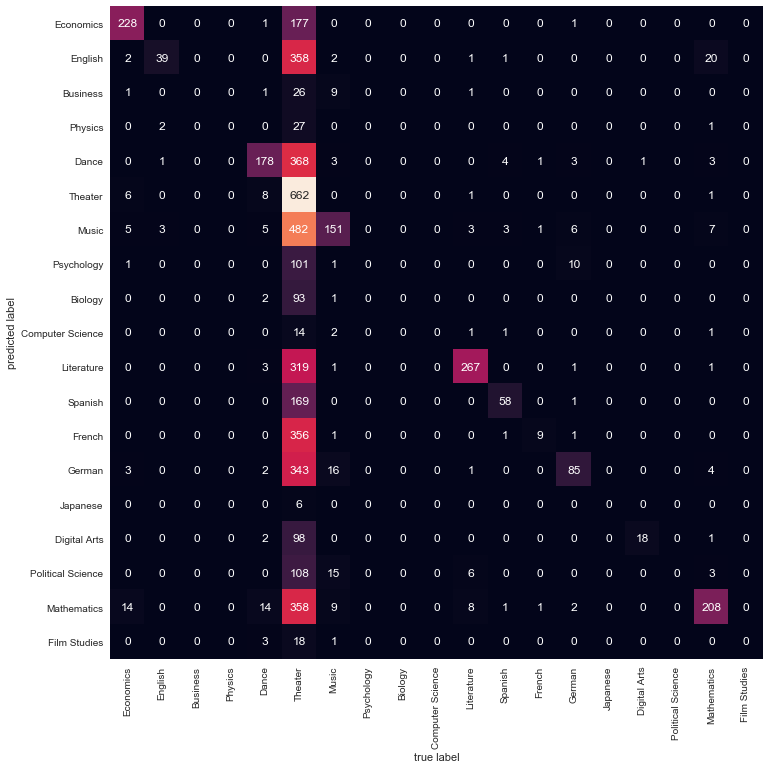

Accuracy Score:  0.341774425287


In [56]:
tree = DecisionTreeClassifier(max_depth=30)
bag = BaggingClassifier(tree, n_estimators=1000, max_samples=0.95, random_state=42, n_jobs=4)

X_train, X_test, y_train, y_test = train_test_split(X_discipline,y_discipline,test_size = 0.3,random_state = 42)

bag.fit(X_train,y_train)
y_discipline_pred = bag.predict(X_test)

seaborn_confusion(y_test,y_discipline_pred,fake_disciplines)

### So, that didn't work too well

### Let's change gears a bit, and focus on Region instead

* Asia
* Europe
* Latin America and Caribbean
* North America (minus the US—more about that later)
* Africa
* Oceania
* Middle East

#### TFIDF


In [93]:
tf = TfidfVectorizer()
vectorized = tf.fit_transform(corrected['Full Text'])
vectorized = vectorized.toarray()

#### So what does the resulting data look like?

In [94]:
display(vectorized)
print('Amount of non-zeros: ',np.count_nonzero(vectorized))
print('Total size: ',vectorized.shape[0] * vectorized.shape[1])
print('Shape of data: ',vectorized.shape)

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

Amount of non-zeros:  353150
Total size:  13421328
Shape of data:  (368, 36471)


In [95]:
# we can take a look at it as a data frame
text_vectorized_df = pd.DataFrame(vectorized, columns=tf.get_feature_names())
display(text_vectorized_df.head(n=8))

,00,000,0000,0002,0007,0008,000ff,000km,000s,000tsh,...,óczech,ódrive,óglaigh,ónot,österreichische,øystein,última,últimos,únicamente,œ35
0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.011526,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.003807,0.010565,0.0,0.0,0.0,0.0,0.000000,0.0,0.006373,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000000,0.019475,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.000000,0.018396,0.0,0.0,0.0,0.0,0.040877,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.000000,0.003551,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### This data exists in 36,471 dimensions… that's a bit difficult to work with

#### PCA to reduce dimensions

Shape of data:  (368, 2) 

First few rows of data: 
 [[ 0.5150565  -0.00465907]
 [ 0.10180482  0.08966593]
 [ 0.29779684 -0.01336801]
 [-0.15163081 -0.02687646]
 [-0.24121412 -0.00087286]
 [-0.09808845 -0.04300494]
 [-0.08563942 -0.03165657]
 [-0.07346245  0.00292217]
 [ 0.07061543  0.6063206 ]
 [-0.38676899  0.04786697]]


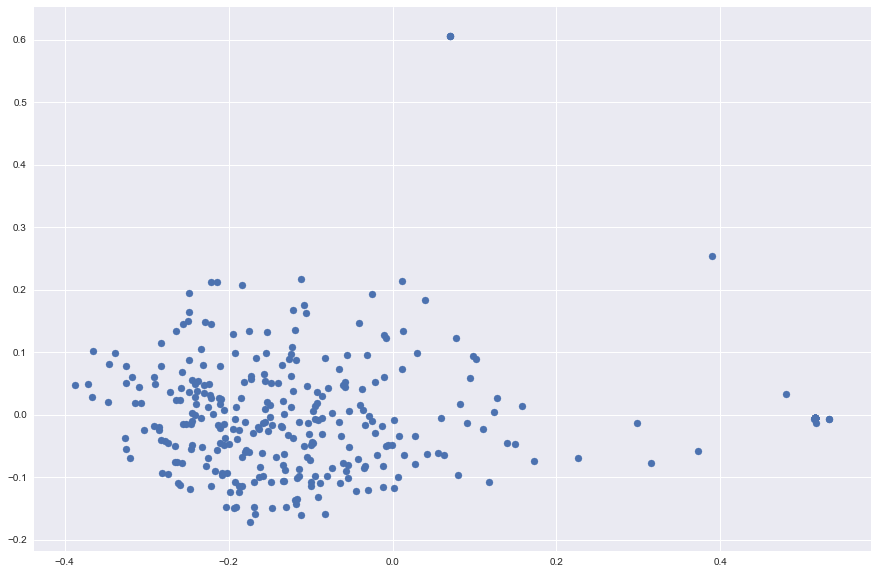

In [96]:
vector_reduced = PCA(2).fit_transform(vectorized)
print('Shape of data: ',vector_reduced.shape,'\n')
print('First few rows of data: \n',vector_reduced[:10,:])
fig, ax = plt.subplots(figsize=(15,10))
plt.scatter(vector_reduced[:,0],vector_reduced[:,1])
plt.show()

#### Two dimensions is reducing it a little too much, though
Let's see what happens when we reduce it down by a factor of 100:

In [63]:
# defining a helper function to transform text data through TFIDF and then through PCA
def vectorize_and_pca(series):
    tf = TfidfVectorizer()
    t = tf.fit_transform(series)
    pca = PCA(360)
    p = pca.fit_transform(t.toarray())
    return p


Now to transform my text data through TF-IDF and PCA, for both my corrected and uncorrected data. 

This takes _forever_ to run.

In [112]:
corrected_X = vectorize_and_pca(corrected['Full Text'])
non_corrected_X = vectorize_and_pca(non_corrected['Full Text'])

In [113]:
# the labels to predict on
corrected_y = corrected['Region']
non_corrected_y = non_corrected['Region']

Time to train and test the model.

In [114]:
X_train, X_test, y_train, y_test = train_test_split(corrected_X, corrected_y, test_size=0.3, random_state=42)

tree = DecisionTreeClassifier(max_depth=30, max_features=0.2)
bag = BaggingClassifier(tree, n_estimators=1000, max_samples=0.95, random_state=42, n_jobs=4)

bag.fit(X_train,y_train)

y_pred = bag.predict(X_test)

### The moment of truth
Alright, let's see how the model did:

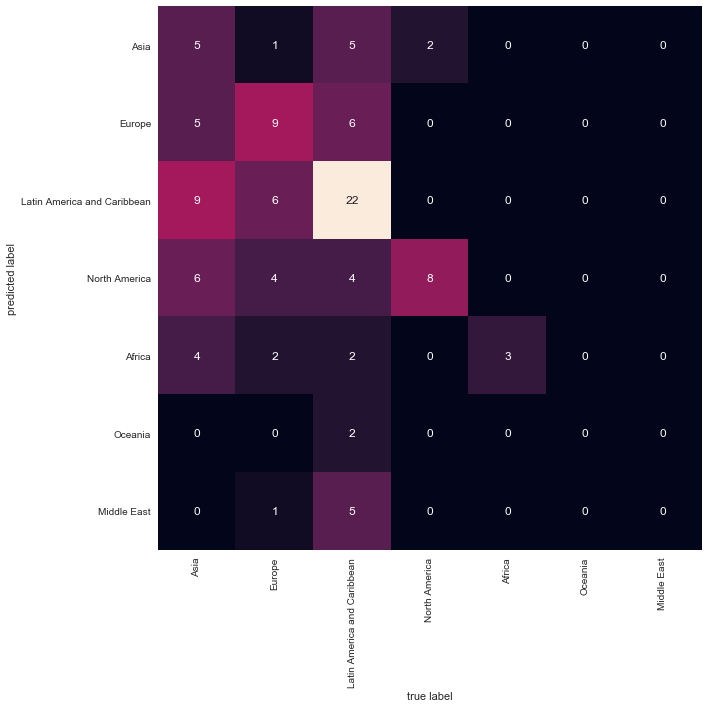

Accuracy Score:  0.423423423423


In [85]:
seaborn_confusion(y_test, y_pred, corrected_y.unique(), size=(10,10))

Well, that's not all that accurate either. Hmm.

### Life is easier if you aim lower

In [65]:
us_corrected = pd.read_excel('/usr/local/etc/ml/audited/final/us_audited.xlsx').fillna('')
us_non_corrected = pd.read_excel('/usr/local/etc/ml/cached_us/us_not_audited_final_labels.xlsx').fillna('')

us_corrected_y = us_corrected['US']
us_non_corrected_y = us_non_corrected['US']

In [91]:
# I already ran these through the TFDIF Vectorizer and wrote them out to Excel files
us_corrected_X = pd.read_excel('/usr/local/etc/ml/cached_us/us_audited_final.xlsx')
us_non_corrected_X = pd.read_excel('/usr/local/etc/ml/cached_us/us_not_audited_final.xlsx')
display(us_corrected_X.head(n=10))

,0,1,2,3,4,5,6,7,8,9,...,350,351,352,353,354,355,356,357,358,359
0,0.043460,-0.023899,-0.064787,-0.029098,-0.004401,-0.028219,-0.014050,-0.025880,0.033858,0.006050,...,-0.003144,-0.007207,0.003598,0.007519,0.006084,0.002509,0.000077,0.000827,-0.002017,0.007634
1,0.160352,-0.062425,-0.054261,-0.049433,-0.008973,-0.084253,0.010351,-0.039161,0.017891,-0.001367,...,0.001155,0.002155,-0.004420,0.001109,-0.019156,-0.002818,0.006414,-0.000636,0.007402,0.004054
2,0.267238,0.015853,-0.001539,-0.121180,-0.059649,-0.059369,-0.004137,0.032635,0.108848,-0.051787,...,-0.004118,-0.003977,-0.001746,-0.001515,0.000269,-0.000028,0.003425,0.000794,0.004261,0.003739
3,-0.020132,0.096164,-0.019273,0.141601,0.043012,-0.118151,0.083584,0.014089,0.011015,0.013326,...,-0.019448,-0.021038,0.004218,0.001469,-0.000875,0.013060,-0.020076,-0.004647,-0.003965,0.016300
4,-0.010135,0.118624,-0.090716,0.007146,0.040417,-0.006208,-0.018953,0.016776,0.000812,0.043262,...,0.008386,-0.008994,0.000158,0.006702,-0.018432,-0.001941,-0.006630,-0.011143,0.004888,-0.012388
5,0.252438,-0.038243,-0.105052,-0.142914,0.036442,-0.154341,-0.198867,0.291626,-0.299679,0.306490,...,-0.000683,-0.011977,-0.006776,0.002218,-0.011463,-0.005808,-0.001301,0.002692,0.000763,0.004445
6,-0.043005,0.083600,-0.092337,-0.061475,-0.010020,0.071488,-0.023476,0.050248,-0.015588,-0.094272,...,-0.026419,0.020948,0.002800,-0.014033,0.017951,0.025849,-0.019285,0.008247,-0.041565,0.021448
7,0.188002,0.068882,-0.002764,0.006232,0.069340,0.067621,-0.104759,-0.065669,0.143060,-0.088183,...,-0.004333,0.001396,0.005197,0.008470,-0.008718,0.008348,-0.001731,0.005242,-0.010374,0.000126
8,0.013183,0.248550,-0.016882,0.073725,-0.007160,-0.080867,0.079145,0.019932,-0.040799,0.015519,...,0.023598,0.027339,0.012714,0.000147,0.018287,0.016958,-0.009635,-0.010562,0.015984,-0.007348
9,0.003605,-0.048459,-0.099383,0.010101,0.084558,-0.100972,-0.088744,0.075696,-0.059286,0.055986,...,0.002566,0.006205,-0.007870,-0.002155,-0.013487,-0.002169,0.001904,0.003865,-0.001550,0.001103


In [67]:
X_train_us, X_test_us, y_train_us, y_test_us = train_test_split(us_corrected_X, us_corrected_y, random_state=42)

us_tree = DecisionTreeClassifier(max_depth=30)
us_bag = BaggingClassifier(us_tree, n_estimators=1000, random_state=42, n_jobs=4)

us_bag.fit(X_train_us, y_train_us)

y_pred_us = us_bag.predict(X_test_us)

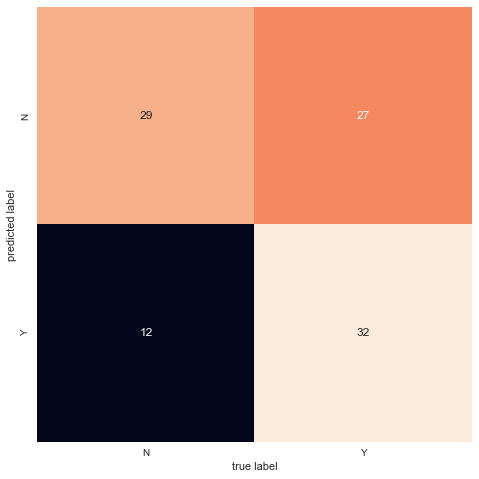

Accuracy Score:  0.61


In [68]:
seaborn_confusion(y_test_us, y_pred_us, us_corrected_y.unique(), size=(8,8))

That's the highest score so far, but it's still not _great_.

### Conclusions


### Where to go from here


That's it! It's a story of how I learned through failure. 